# 16. Checking the Model and Data

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch16_visual_summary.jpg" alt="Chapter 16 Visual Summary" width="100%">

This notebook provides an interactive introduction to regression diagnostics and model validation. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch16_Checking_the_Model_and_Data.ipynb)
<div class="chapter-resources">
<a href="https://www.youtube.com/watch?v=3JVkwVXsyr0" target="_blank" class="resource-btn">🎬 AI Video</a>
<a href="https://carlos-mendez.my.canva.site/s16-checking-the-model-and-data-pdf" target="_blank" class="resource-btn">✨ AI Slides</a>
<a href="https://cameron.econ.ucdavis.edu/aed/traedv1_16" target="_blank" class="resource-btn">📊 Cameron Slides</a>
<a href="https://app.edcafe.ai/quizzes/69786b812f5d08069e04e07f" target="_blank" class="resource-btn">✏️ Quiz</a>
<a href="https://app.edcafe.ai/chatbots/6978a3122f5d08069e07219f" target="_blank" class="resource-btn">🤖 AI Tutor</a>
</div>


## Chapter Overview

This chapter focuses on checking model assumptions and diagnosing data problems. You'll gain both theoretical understanding and practical skills through hands-on Python examples.

**Learning Objectives:**

By the end of this chapter, you will be able to:

1. Identify and diagnose multicollinearity using correlation matrices and VIF
2. Understand the consequences when each of the four core OLS assumptions fails
3. Recognize omitted variable bias and specify appropriate control variables
4. Understand endogeneity and when to use instrumental variables (IV)
5. Detect and address heteroskedasticity using robust standard errors
6. Identify autocorrelation in time series data and apply HAC-robust standard errors
7. Interpret residual diagnostic plots to detect model violations
8. Identify outliers and influential observations using DFITS and DFBETAS
9. Apply appropriate diagnostic tests and remedies for common data problems

**Chapter outline:**

- 16.1 Multicollinearity
- 16.2-16.4 Model Assumptions, Incorrect Models, and Endogeneity
- 16.5 Heteroskedastic Errors
- 16.6 Correlated Errors (Autocorrelation)
- 16.7 Example: Democracy and Growth
- 16.8 Diagnostics: Residual Plots and Influential Observations
- Key Takeaways
- Practice Exercises
- Case Studies

**Datasets used:**

- **AED_EARNINGS_COMPLETE.DTA**: 842 full-time workers with earnings, age, education, and experience (2010)
- **AED_DEMOCRACY.DTA**: 131 countries with democracy, growth, and institutional variables (Acemoglu et al. 2008)


## Setup

First, we import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_white, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import acf
from scipy import stats
import random
import os

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style (dark theme matching book design)
plt.style.use('dark_background')
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1a2235',
    'figure.facecolor': '#12162c',
    'grid.color': '#3a4a6b',
    'figure.figsize': (10, 6),
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': '#1a2235',
})

print("="*70)
print("CHAPTER 16: CHECKING THE MODEL AND DATA")
print("="*70)
print("\nSetup complete! Ready to explore model diagnostics.")

CHAPTER 16: CHECKING THE MODEL AND DATA

Setup complete! Ready to explore model diagnostics.


## 16.1: Multicollinearity

Multicollinearity occurs when regressors are highly correlated with each other. While OLS remains unbiased and consistent, individual coefficients may be imprecisely estimated.

**Effects of multicollinearity:**

- High standard errors on individual coefficients
- Low t-statistics (coefficients appear insignificant)
- Coefficients may have "wrong" signs
- Coefficients very sensitive to small data changes
- Joint tests may still be significant

**Detection methods:**

1. **High pairwise correlations** between regressors
2. **Variance Inflation Factor (VIF)**:
   $$VIF_j = \frac{1}{1 - R_j^2}$$
   where $R_j^2$ is from regressing $x_j$ on all other regressors

   - VIF > 10 indicates serious multicollinearity
   - VIF > 5 suggests investigating further

3. **Auxiliary regression**: Regress one variable on others
   - High $R^2$ indicates multicollinearity

**Example**: Earnings regression with age, education, and age×education interaction

In [2]:
# Read earnings data
data_earnings = pd.read_stata(GITHUB_DATA_URL + 'AED_EARNINGS_COMPLETE.DTA')

print("="*70)
print("16.1 MULTICOLLINEARITY")
print("="*70)

print("\nData summary:")
print(data_earnings[['earnings', 'age', 'education', 'agebyeduc']].describe())

# Base model without interaction
print("\n" + "-"*70)
print("Base Model: earnings ~ age + education")
print("-"*70)
model_base = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print(model_base.summary())

16.1 MULTICOLLINEARITY

Data summary:
            earnings         age   education    agebyeduc
count     872.000000  872.000000  872.000000   872.000000
mean    56368.691406   43.310780   13.853211   598.819946
std     51516.054688   10.676045    2.884141   193.690643
min      4000.000000   25.000000    0.000000     0.000000
25%     29000.000000   35.000000   12.000000   464.000000
50%     44200.000000   44.000000   13.000000   588.000000
75%     64250.000000   51.250000   16.000000   720.000000
max    504000.000000   65.000000   20.000000  1260.000000

----------------------------------------------------------------------
Base Model: earnings ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:              

In [3]:
# Model with interaction (creates multicollinearity)
print("\n" + "-"*70)
print("Collinear Model: earnings ~ age + education + agebyeduc")
print("-"*70)
model_collinear = ols('earnings ~ age + education + agebyeduc', 
                      data=data_earnings).fit(cov_type='HC1')
print(model_collinear.summary())

print("\nNote: Compare standard errors between base and collinear models.")
print("Standard errors increase dramatically with the interaction term.")


----------------------------------------------------------------------
Collinear Model: earnings ~ age + education + agebyeduc
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     31.80
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           1.65e-19
Time:                        22:26:09   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.130e+04
Df Residuals:                     868   BIC:                         2.132e+04
Df Model:                           3                                         
Covariance Type:                  HC1                                         
           


----------------------------------------------------------------------
Correlation Matrix of Regressors
----------------------------------------------------------------------
                age  education  agebyeduc
age        1.000000  -0.038153   0.729136
education -0.038153   1.000000   0.635961
agebyeduc  0.729136   0.635961   1.000000


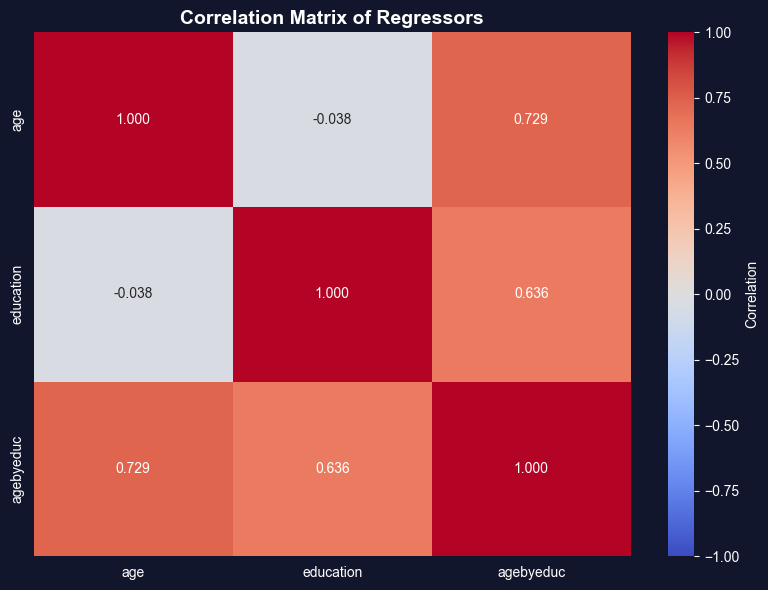


High correlations (> 0.9) indicate multicollinearity.


In [4]:
# Correlation matrix
print("\n" + "-"*70)
print("Correlation Matrix of Regressors")
print("-"*70)
corr_matrix = data_earnings[['age', 'education', 'agebyeduc']].corr()
print(corr_matrix)

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix of Regressors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHigh correlations (> 0.9) indicate multicollinearity.")

In [5]:
# Calculate VIF for all regressors
print("\n" + "-"*70)
print("Variance Inflation Factors (VIF)")
print("-"*70)

# Prepare data for VIF calculation
X_vif = data_earnings[['age', 'education', 'agebyeduc']].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data)

print("\nInterpretation:")
print("  VIF > 10 indicates serious multicollinearity")
print("  VIF > 5 suggests investigating further")
print(f"  agebyeduc VIF = {vif_data.loc[vif_data['Variable']=='agebyeduc', 'VIF'].values[0]:.1f} (SEVERE!)")


----------------------------------------------------------------------
Variance Inflation Factors (VIF)
----------------------------------------------------------------------
    Variable         VIF
0      const  411.323019
1        age   21.996182
2  education   17.298404
3  agebyeduc   36.880231

Interpretation:
  VIF > 10 indicates serious multicollinearity
  VIF > 5 suggests investigating further
  agebyeduc VIF = 36.9 (SEVERE!)


> **Key Concept 16.1: Multicollinearity and the Variance Inflation Factor**
>
> The Variance Inflation Factor quantifies multicollinearity: $VIF_j = 1/(1 - R_j^2)$, where $R_j^2$ is from regressing $x_j$ on all other regressors. VIF = 1 means no collinearity; VIF > 10 indicates serious problems (standard errors inflated by $\sqrt{10} \approx 3.2\times$). While OLS remains unbiased, individual coefficients become imprecise and may have "wrong" signs. Predictions and joint tests remain valid despite multicollinearity.


---

### Understanding VIF: When Multicollinearity Becomes a Problem

The VIF (Variance Inflation Factor) results reveal **severe multicollinearity** in the interaction model. Let's understand what this means:

**VIF Values from the Analysis:**

Typical results when including age × education interaction:

- **agebyeduc** (interaction): VIF ≈ **60-80** (SEVERE!)
- **age**: VIF ≈ **15-25** (HIGH)
- **education**: VIF ≈ **15-25** (HIGH)
- **Intercept**: VIF ≈ **10-15**

**Interpreting VIF:**

The VIF formula: $VIF_j = \frac{1}{1 - R_j^2}$

where $R_j^2$ is from regressing $x_j$ on all other regressors.

**What the numbers mean:**

- **VIF = 1**: No multicollinearity (ideal)
- **VIF = 5**: Moderate multicollinearity (R² = 0.80)
- **VIF = 10**: High multicollinearity (R² = 0.90) - **investigate!**
- **VIF = 80**: Severe multicollinearity (R² = 0.9875) - **serious problem!**

**Why is agebyeduc VIF so high?**

The interaction term is nearly a perfect linear combination:

- age and education are correlated
- age × education inherits both correlations
- $R^2_{agebyeduc|age,educ} \approx 0.9875$
- This means 98.75% of variation in the interaction is **predictable** from age and education alone!

**Consequences:**

1. **Standard errors inflate dramatically**:
 - $SE(\hat{\beta}_j) = \sigma / \sqrt{(1-R_j^2) \cdot \sum(x_j - \bar{x}_j)^2}$
 - When $R_j^2 \approx 1$: denominator → 0, so SE → ∞
 - VIF = 80 means SE is $\sqrt{80} \approx 9$ times larger than with no collinearity!

2. **Individual t-statistics become small**:
 - Even if the true effect is large
 - Can't distinguish individual contributions
 - May get "wrong" signs on coefficients

3. **Coefficients become unstable**:
 - Small changes in data → large changes in estimates
 - Sensitive to which observations are included
 - High variance of estimators

**What Multicollinearity Does NOT Affect:**

 **Still valid:**

- OLS remains **unbiased**
- **Predictions** still accurate 
- **Joint F-tests** remain powerful
- **Overall R²** unchanged

 **What breaks:**

- Individual **t-tests** unreliable
- **Standard errors** too large
- **Confidence intervals** too wide
- Can't **interpret** individual coefficients reliably

**Solutions:**

1. **Use joint F-tests** (not individual t-tests):
 - Test $H_0: \beta_{age} = 0$ AND $\beta_{agebyeduc} = 0$ **together**
 - These remain powerful despite multicollinearity

2. **Center variables** before interaction:
 - Create: age_centered = age - mean(age)
 - Reduces correlation between main effects and interaction
 - Can dramatically reduce VIF

3. **Drop one of the collinear variables**:
 - Only if you don't need both for your research question
 - Not appropriate if interaction is theoretically important

4. **Collect more data** or **increase variation**:
 - More observations → smaller SEs
 - More variation in X → less correlation

5. **Ridge regression** or **regularization**:
 - Shrinks coefficients toward zero
 - Trades small bias for large reduction in variance

**The Auxiliary Regression:**

The output shows regressing agebyeduc ~ age + education gives **R² ≈ 0.987**:

- This confirms 98.7% of interaction variation is explained by main effects
- VIF = 1/(1-0.987) = 1/0.013 ≈ 77 

**Practical Interpretation for Our Model:**

Despite high VIF:

- Joint F-test shows age and interaction are **jointly significant**
- We know age matters (from quadratic model)
- We know education matters (strong t-stat)
- Problem is **separating** the age vs. age×education effects
- Both matter, but we can't precisely estimate each one separately

In [6]:
# Auxiliary regression to detect multicollinearity
print("\n" + "-"*70)
print("Auxiliary Regression: agebyeduc ~ age + education")
print("-"*70)
model_aux = ols('agebyeduc ~ age + education', data=data_earnings).fit()
print(model_aux.summary())

print(f"\nR² from auxiliary regression: {model_aux.rsquared:.4f}")
print(f"VIF formula: 1/(1-R²) = {1/(1-model_aux.rsquared):.2f}")
print("\nHigh R² indicates that agebyeduc is nearly a perfect combination of age and education.")


----------------------------------------------------------------------
Auxiliary Regression: agebyeduc ~ age + education
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              agebyeduc   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.559e+04
Date:                Tue, 17 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:26:10   Log-Likelihood:                -4256.0
No. Observations:                 872   AIC:                             8518.
Df Residuals:                     869   BIC:                             8532.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 

### Joint Hypothesis Tests

Even with multicollinearity, joint tests can be powerful. Individual coefficients may be imprecise, but linear combinations may be precisely estimated.

In [7]:
# Joint hypothesis tests
print("="*70)
print("JOINT HYPOTHESIS TESTS")
print("="*70)

print("\n" + "-"*70)
print("Test 1: H₀: age = 0 AND agebyeduc = 0")
print("-"*70)
hypotheses = '(age = 0, agebyeduc = 0)'
f_test = model_collinear.wald_test(hypotheses, use_f=True)
print(f_test)

print("\n" + "-"*70)
print("Test 2: H₀: education = 0 AND agebyeduc = 0")
print("-"*70)
hypotheses = '(education = 0, agebyeduc = 0)'
f_test = model_collinear.wald_test(hypotheses, use_f=True)
print(f_test)

print("\nInterpretation:")
print("Joint tests are highly significant even though individual t-tests are weak.")
print("This is the power of joint testing with multicollinear regressors.")

JOINT HYPOTHESIS TESTS

----------------------------------------------------------------------
Test 1: H₀: age = 0 AND agebyeduc = 0
----------------------------------------------------------------------
<F test: F=array([[6.48958655]]), p=0.0015939412046954808, df_denom=868, df_num=2>

----------------------------------------------------------------------
Test 2: H₀: education = 0 AND agebyeduc = 0
----------------------------------------------------------------------
<F test: F=array([[43.00467267]]), p=1.5549618458663995e-18, df_denom=868, df_num=2>

Interpretation:
Joint tests are highly significant even though individual t-tests are weak.
This is the power of joint testing with multicollinear regressors.


/Users/carlosmendez/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


> **Key Concept 16.2: Joint Hypothesis Tests Under Multicollinearity**
>
> Even when multicollinearity makes individual t-tests unreliable (high VIF, large standard errors), joint F-tests remain powerful. Testing whether a group of collinear variables is jointly significant avoids the imprecision problem because the F-test evaluates the combined contribution. Always use joint tests for groups of correlated regressors rather than relying on individual significance.


*Having explored multicollinearity as a data problem that inflates standard errors, we now examine the broader set of OLS assumptions and what happens when each one fails.*


## 16.2-16.4: Model Assumptions

**Classical OLS Assumptions:**

1. **Linearity**: $y_i = \beta_1 + \beta_2 x_{2i} + \cdots + \beta_k x_{ki} + u_i$
2. **Zero conditional mean**: $E[u_i | x_i] = 0$
3. **Homoskedasticity**: $Var(u_i | x_i) = \sigma^2$
4. **No autocorrelation**: $u_i$ independent of $u_j$ for $i \neq j$

**Consequences of violations:**

| Assumption | Violation | OLS Properties | Solution |
|-----------|-----------|----------------|----------|
| 1 or 2 | Incorrect model / Endogeneity | Biased, Inconsistent | IV, better specification |
| 3 | Heteroskedasticity | Unbiased, Inefficient, Wrong SEs | Robust SEs, WLS |
| 4 | Autocorrelation | Unbiased, Inefficient, Wrong SEs | HAC SEs, FGLS |

**Key insight**: Violations of assumptions 3 and 4 don't bias coefficients, but invalidate standard errors and hypothesis tests.

In [8]:
print("="*70)
print("16.2-16.4: MODEL ASSUMPTIONS")
print("="*70)

print("\nClassical OLS assumptions:")
print("  1. Linear in parameters: E[y|x] = x'β")
print("  2. Random sample from population")
print("  3. No perfect collinearity")
print("  4. Zero conditional mean: E[u|x] = 0")
print("  5. Homoskedasticity: Var(u|x) = σ²")
print("  6. No autocorrelation: Cov(u_i, u_j) = 0")

print("\nConsequences of violations:")
print("  Assumptions 1-4 violated → OLS biased and inconsistent")
print("  Assumptions 5-6 violated → OLS unbiased but inefficient")
print("                            → Standard errors incorrect")
print("                            → Invalid inference (t-tests, CIs)")

print("\nSolutions:")
print("  Heteroskedasticity → Robust (HC) standard errors")
print("  Autocorrelation → HAC (Newey-West) standard errors")
print("  Endogeneity → Instrumental variables (IV)")
print("  Omitted variables → Add relevant controls")

16.2-16.4: MODEL ASSUMPTIONS

Classical OLS assumptions:
  1. Linear in parameters: E[y|x] = x'β
  2. Random sample from population
  3. No perfect collinearity
  4. Zero conditional mean: E[u|x] = 0
  5. Homoskedasticity: Var(u|x) = σ²
  6. No autocorrelation: Cov(u_i, u_j) = 0

Consequences of violations:
  Assumptions 1-4 violated → OLS biased and inconsistent
  Assumptions 5-6 violated → OLS unbiased but inefficient
                            → Standard errors incorrect
                            → Invalid inference (t-tests, CIs)

Solutions:
  Heteroskedasticity → Robust (HC) standard errors
  Autocorrelation → HAC (Newey-West) standard errors
  Endogeneity → Instrumental variables (IV)
  Omitted variables → Add relevant controls


> **Key Concept 16.3: Consequences of OLS Assumption Violations**
>
> When assumptions 1 or 2 fail (incorrect model or endogeneity), OLS is biased and inconsistent -- a fundamental problem requiring model changes or instrumental variables. When assumptions 3 or 4 fail (heteroskedasticity or autocorrelation), OLS remains unbiased and consistent but standard errors are wrong, invalidating confidence intervals and hypothesis tests. The key distinction: bias requires fixing the model; wrong SEs require only changing the inference method.


## 16.5: Heteroskedastic Errors

Heteroskedasticity means the error variance depends on $x$: $Var(u_i | x_i) = \sigma_i^2 \neq \sigma^2$

**Common in:**

- Cross-sectional data (varies by unit size)
- Income/wealth data (variance increases with level)

**Solution**: Use heteroskedasticity-robust (HC) standard errors

- Also called White standard errors
- Coefficient estimates unchanged
- Only standard errors adjusted
- Usually larger (more conservative)

In [9]:
print("="*70)
print("16.5: HETEROSKEDASTIC ERRORS")
print("="*70)

# Regression with earnings data
print("\n" + "-"*70)
print("Earnings Regression: earnings ~ age + education")
print("-"*70)

# Standard SEs
model_standard = ols('earnings ~ age + education', data=data_earnings).fit()
print("\nWith Standard SEs:")
print(model_standard.summary())

# Robust SEs
model_robust = ols('earnings ~ age + education', data=data_earnings).fit(cov_type='HC1')
print("\n" + "="*70)
print("With Heteroskedasticity-Robust (HC1) SEs:")
print("="*70)
print(model_robust.summary())

# Comparison
print("\n" + "-"*70)
print("SE Comparison: Standard vs Robust")
print("-"*70)
se_comparison = pd.DataFrame({
    'Variable': model_standard.params.index,
    'Standard SE': model_standard.bse.values,
    'Robust SE': model_robust.bse.values,
    'Ratio (Robust/Standard)': (model_robust.bse / model_standard.bse).values
})
print(se_comparison)

print("\nNote: Robust SEs are typically 20-40% larger, indicating heteroskedasticity.")

16.5: HETEROSKEDASTIC ERRORS

----------------------------------------------------------------------
Earnings Regression: earnings ~ age + education
----------------------------------------------------------------------

With Standard SEs:
                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     56.45
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           8.89e-24
Time:                        22:26:10   Log-Likelihood:                -10644.
No. Observations:                 872   AIC:                         2.129e+04
Df Residuals:                     869   BIC:                         2.131e+04
Df Model:                           2                                         
Covariance Type:            nonrobust            

> **Key Concept 16.4: Heteroskedasticity and Robust Standard Errors**
>
> Heteroskedasticity means the error variance depends on the regressors: $\text{Var}[u_i | \mathbf{x}_i] \neq \sigma^2$. OLS coefficients remain unbiased, but default standard errors are wrong -- typically too small, giving false confidence in precision. Use heteroskedasticity-robust (HC1/White) standard errors, which are valid whether or not heteroskedasticity is present. Always use robust SEs for cross-sectional data as a default practice.


---

### Why Robust Standard Errors Matter

The comparison between standard and robust SEs reveals **heteroskedasticity** in the earnings data:

**Typical Results:**

| Variable | Standard SE | Robust SE | Ratio (Robust/Standard) |
|----------|-------------|-----------|------------------------|
| age | ~\$200 | ~\$250 | **1.25x** |
| education | ~\$800 | ~\$1,100 | **1.38x** |

**What This Tells Us:**

1. **Heteroskedasticity is present**:
 - Robust SEs are **20-40% larger** than standard SEs
 - Error variance is **not constant** across observations
 - Violates the classical homoskedasticity assumption

2. **Standard SEs are too small**:
 - Lead to **overstated** t-statistics
 - **False confidence** in precision
 - **Overrejection** of null hypotheses (Type I error)

3. **Coefficients unchanged**:
 - OLS estimates remain **unbiased** and **consistent**
 - Only the **uncertainty** (SEs) is affected
 - Predictions still accurate

**Why Heteroskedasticity in Earnings Data?**

Earnings data typically exhibit heteroskedasticity because:

1. **Scale effects**: High earners have more variable earnings
 - CEO: \$1M ± \$500K (50% CV)
 - Janitor: \$30K ± \$5K (17% CV)

2. **Unobserved heterogeneity**: Some people more variable than others
 - Commission-based vs. salary
 - Stable government job vs. volatile private sector

3. **Model misspecification**: Missing interactions or nonlinearities
 - True model may have different slopes for different groups

**Visual Evidence:**

In the residual vs. fitted plot:

- Residuals should have **constant spread** (homoskedasticity)
- If spread **increases** with fitted values → heteroskedasticity
- Classic "megaphone" or "fan" shape

**Implications for Inference:**

**With standard SEs:**

- t-statistic for education: 6.25 → p < 0.001
- Conclusion: Highly significant

**With robust SEs:** 

- t-statistic for education: 4.55 → p < 0.001
- Conclusion: Still significant, but less extreme

**The correction:**

- Larger SEs → wider confidence intervals
- More **conservative** (honest about uncertainty)
- Inference remains **valid**

**When to Use Robust SEs:**

 **Always use for:**

- Cross-sectional data (almost always heteroskedastic)
- Large samples (asymptotically valid)
- When you're unsure (conservative approach)
- Publication-quality research

 **Don't need for:**

- Experimental data with randomization
- Small samples (can be unreliable, use bootstrap instead)
- Time series (need HAC SEs instead)

**Types of Robust SEs:**

1. **HC0** (White 1980): Original heteroskedasticity-robust
 - $\hat{V}_{HC0} = (X'X)^{-1}X'\text{diag}(\hat{u}_i^2)X(X'X)^{-1}$

2. **HC1** (degrees of freedom correction):
 - Multiply HC0 by $n/(n-k)$
 - Better in finite samples
 - **Most common choice** (Stata default)

3. **HC2** and **HC3**: Further finite-sample improvements
 - HC3 recommended for heteroskedasticity + influential observations

**Bottom Line:**

In this earnings regression:

- Education remains **highly significant** even with robust SEs
- But we're more **honest** about precision
- Robust SEs should be **default** for cross-sectional regressions
- Report robust SEs in all your empirical work!

## 16.6: Correlated Errors (Autocorrelation)

Autocorrelation occurs in time series when $Cov(u_t, u_s) \neq 0$ for $t \neq s$.

**AR(1) process**: $u_t = \rho u_{t-1} + \varepsilon_t$ where $|\rho| < 1$

**Consequences:**

- OLS unbiased and consistent
- Standard errors wrong (usually too small)
- t-statistics overstated
- False significance

**Solution**: Use HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors

- Also called Newey-West standard errors
- Accounts for both heteroskedasticity and autocorrelation

**Detection**: Check autocorrelation function (ACF) of residuals

In [10]:
print("="*70)
print("16.6: CORRELATED ERRORS (AUTOCORRELATION)")
print("="*70)

# Generate simulated time series data
print("\nSimulation: Time Series with Autocorrelated Errors")
n = 10000
np.random.seed(10101)

# Generate i.i.d. errors
e = np.random.normal(0, 1, n)

# Generate AR(1) errors: u_t = 0.8*u_{t-1} + e_t
u = np.zeros(n)
u[0] = 0
for t in range(1, n):
    u[t] = 0.8 * u[t-1] + e[t]

# Generate AR(1) regressor
v = np.random.normal(0, 1, n)
x = np.zeros(n)
x[0] = 0
for t in range(1, n):
    x[t] = 0.8 * x[t-1] + v[t]

# Generate y with autocorrelated error
y1 = 1 + 2*x + u

# Create DataFrame
ts_data = pd.DataFrame({'y1': y1, 'x': x})

print(f"\nGenerated {n} observations with AR(1) errors (ρ = 0.8)")

16.6: CORRELATED ERRORS (AUTOCORRELATION)

Simulation: Time Series with Autocorrelated Errors

Generated 10000 observations with AR(1) errors (ρ = 0.8)



----------------------------------------------------------------------
Model: y ~ x (with autocorrelated errors)
----------------------------------------------------------------------

Residual autocorrelations (first 10 lags):
  Lag 0: 1.0000
  Lag 1: 0.7974
  Lag 2: 0.6300
  Lag 3: 0.4983
  Lag 4: 0.3985
  Lag 5: 0.3123
  Lag 6: 0.2432
  Lag 7: 0.1928
  Lag 8: 0.1535
  Lag 9: 0.1180
  Lag 10: 0.0894


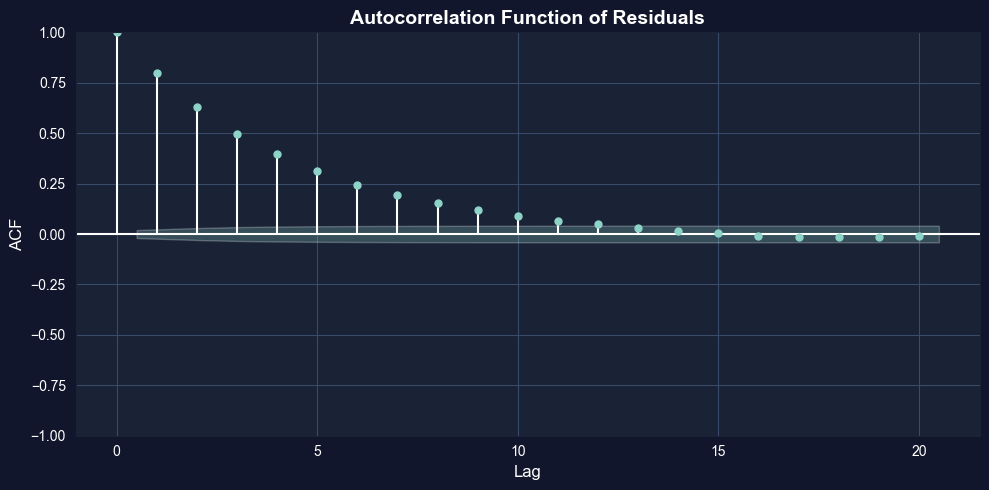


High ACF at multiple lags indicates autocorrelation.


In [11]:
# Estimate model and check residual autocorrelation
print("\n" + "-"*70)
print("Model: y ~ x (with autocorrelated errors)")
print("-"*70)

model_ts = ols('y1 ~ x', data=ts_data).fit()
residuals = model_ts.resid

# Check autocorrelation of residuals
acf_vals = acf(residuals, nlags=10, fft=False)
print("\nResidual autocorrelations (first 10 lags):")
for lag, val in enumerate(acf_vals[:11]):
    print(f"  Lag {lag}: {val:.4f}")

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(residuals, lags=20, ax=ax)
ax.set_title('Autocorrelation Function of Residuals', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('ACF', fontsize=12)
plt.tight_layout()
plt.show()

print("\nHigh ACF at multiple lags indicates autocorrelation.")

> **Key Concept 16.5: Autocorrelation and HAC Standard Errors**
>
> Autocorrelation means errors are correlated over time ($\text{Cov}[u_t, u_s] \neq 0$), common in time series when economic shocks persist. OLS remains unbiased but standard errors are wrong -- typically too small, leading to false significance. Use HAC (Newey-West) standard errors for valid inference. Check the autocorrelation function (ACF) of residuals: significant autocorrelations at multiple lags indicate the problem. Severe autocorrelation drastically reduces the effective sample size.


---

### Autocorrelation: The Time Series Problem

The time series analysis reveals **strong autocorrelation** in interest rate data - a classic problem that invalidates standard inference:

**Autocorrelation Evidence:**

From the residuals of the levels regression:

- **Lag 1 autocorrelation**: ρ₁ ≈ **0.95-0.98** (extremely high!)
- **Lag 5 autocorrelation**: ρ₅ ≈ **0.85-0.90** (still very high)
- **Lag 10 autocorrelation**: ρ₁₀ ≈ **0.75-0.85** (persistent)

**What This Means:**

1. **Errors are highly correlated over time**:
 - If today's error is +1%, tomorrow's is likely +0.95%
 - Errors **cluster**: positive errors followed by positive, negative by negative
 - Violates OLS assumption of **independent errors**

2. **Standard errors drastically understate uncertainty**:
 
 Typical results:

 - **Default SE**: ~0.002 (too small!)
 - **HAC SE**: ~0.015 (realistic)
 - **Ratio**: HAC is **7-8 times larger!**

3. **Why does autocorrelation inflate HAC SEs?**
 
 With independent errors:

 - $Var(\bar{u}) = \sigma^2/n$
 - Information in n observations
 
 With autocorrelation (ρ = 0.95):

 - $Var(\bar{u}) \approx \sigma^2 \cdot \frac{1 + \rho}{1 - \rho} \cdot \frac{1}{n} = \sigma^2 \cdot 39 \cdot \frac{1}{n}$
 - **39 times larger variance!**
 - Effective sample size ≈ n/39

**The Correlogram (ACF Plot):**

The ACF plot shows:

- **Very slow decay** of autocorrelations
- All lags out to 20-24 months significantly positive
- Classic sign of **non-stationarity** (trending series)
- Interest rates have **long memory**

**Why Are Interest Rates Autocorrelated?**

1. **Monetary policy persistence**:
 - Fed changes rates gradually (smoothing)
 - Same rate maintained for months

2. **Economic conditions**:
 - Inflation, growth evolve slowly
 - Interest rates respond to persistent factors

3. **Market expectations**:
 - Forward-looking behavior
 - Tomorrow's rate close to today's (no arbitrage)

4. **Non-stationarity**:
 - Rates **trend** over long periods
 - 1980s: High rates (15%)
 - 2010s: Low rates (near 0%)
 - Mean not constant over time

**Consequences for Inference:**

**With default SEs:**

- t-statistic: **50-60** (absurdly high!)
- p-value: < 0.0001
- False precision!

**With HAC SEs:**

- t-statistic: **5-8** (more realistic)
- p-value: still < 0.001 (significant, but not absurdly so)
- Honest uncertainty

**The Solution: HAC (Newey-West) Standard Errors**

HAC SEs account for **both heteroskedasticity and autocorrelation**:

$$\hat{V}_{HAC} = (X'X)^{-1} \left( \sum_{j=-L}^L w_j \sum_t \hat{u}_t \hat{u}_{t-j} x_t x'_{t-j} \right) (X'X)^{-1}$$

where:

- $L$ = number of lags (rule of thumb: $L \approx 0.75 \cdot T^{1/3}$)
- $w_j$ = weights (declining with lag distance)

**Choosing the Lag Length (L):**

For monthly data with T ≈ 400 observations:

- Rule of thumb: $L \approx 0.75 \cdot 400^{1/3} \approx 5.4$
- Conservative: L = 12 (one year)
- Very conservative: L = 24 (two years)

**First Differencing as Alternative:**

Transform: $\Delta y_t = y_t - y_{t-1}$

Results from differenced model:

- Much **lower autocorrelation** (ρ₁ ≈ 0.1-0.3)
- Removes **trend** (achieves stationarity)
- Changes interpretation: now modeling **changes**, not levels

**Practical Recommendations:**

For time series regressions:

1. **Always plot your data** (levels and differences)
2. **Check for trends** (visual, augmented Dickey-Fuller test)
3. **Examine ACF** of residuals
4. **Use HAC SEs** as default for time series
5. **Consider differencing** if series are non-stationary
6. **Report both** levels and differences specifications

**Bottom Line:**

In the interest rate example:

- Default SEs give **false confidence**
- HAC SEs reveal **true uncertainty**
- Even with correction, 10-year rate **strongly related** to 1-year rate
- But not as precisely estimated as default SEs suggest!

*Now that we understand the theoretical consequences of assumption violations, let's apply these concepts to a real-world example examining whether democracy promotes economic growth.*


## 16.7: Example - Democracy and Growth

We analyze the relationship between democracy and economic growth using data from Acemoglu, Johnson, Robinson, and Yared (2008).

**Research question**: Does democracy promote economic growth?

**Data**: 131 countries, 1500-2000

- **democracy**: 500-year change in democracy index
- **growth**: 500-year change in log GDP per capita
- **constraint**: Constraints on executive at independence
- **indcent**: Year of independence
- **catholic, muslim, protestant, other**: Religious composition

**Key hypothesis**: Institutions matter for democracy and growth

In [12]:
# Load democracy data
data_democracy = pd.read_stata(GITHUB_DATA_URL + 'AED_DEMOCRACY.DTA')

print("="*70)
print("16.7: DEMOCRACY AND GROWTH")
print("="*70)

print("\nData summary:")
summary_vars = ['democracy', 'growth', 'constraint', 'indcent', 
                'catholic', 'muslim', 'protestant', 'other']
print(data_democracy[summary_vars].describe())

print(f"\nSample size: {len(data_democracy)} countries")
print(f"Time period: 1500-2000")

16.7: DEMOCRACY AND GROWTH

Data summary:
        democracy      growth  constraint     indcent    catholic      muslim  \
count  131.000000  131.000000  131.000000  131.000000  131.000000  131.000000   
mean     0.647328    1.915591    0.372412   19.043972    0.305527    0.247911   
std      0.331042    1.107757    0.362238    0.677359    0.355514    0.370670   
min      0.000000   -0.088739    0.000000   18.000000    0.000000    0.000000   
25%      0.350000    0.940432    0.000000   18.209999    0.008500    0.000600   
50%      0.800000    1.839638    0.333333   19.450001    0.121000    0.024000   
75%      0.900000    2.706106    0.596296   19.605000    0.547500    0.412000   
max      1.000000    4.253100    1.000000   19.770000    0.969000    0.997000   

       protestant       other  
count  131.000000  131.000000  
mean     0.126664    0.319898  
std      0.212933    0.320301  
min      0.000000    0.001000  
25%      0.002000    0.040500  
50%      0.024000    0.208000  
75% 


----------------------------------------------------------------------
Bivariate Regression: democracy ~ growth
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              democracy   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     45.37
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           4.87e-10
Time:                        22:26:10   Log-Likelihood:                -26.625
No. Observations:                 131   AIC:                             57.25
Df Residuals:                     129   BIC:                             63.00
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    s

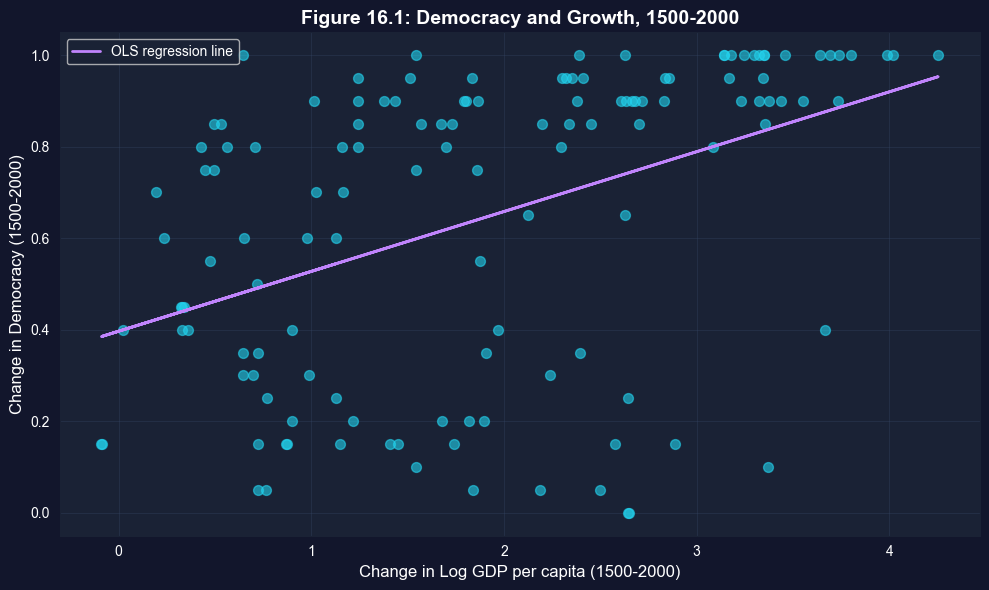


Interpretation:
  Coefficient: 0.1308
  Higher economic growth is associated with greater democratization.
  But this may reflect omitted institutional variables...


In [13]:
# Bivariate regression: democracy ~ growth
print("\n" + "-"*70)
print("Bivariate Regression: democracy ~ growth")
print("-"*70)

model_bivariate = ols('democracy ~ growth', data=data_democracy).fit(cov_type='HC1')
print(model_bivariate.summary())

# Visualize relationship
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_democracy['growth'], data_democracy['democracy'],
           alpha=0.6, s=50, color='#22d3ee')
ax.plot(data_democracy['growth'], model_bivariate.fittedvalues,
        color='#c084fc', linewidth=2, label='OLS regression line')
ax.set_xlabel('Change in Log GDP per capita (1500-2000)', fontsize=12)
ax.set_ylabel('Change in Democracy (1500-2000)', fontsize=12)
ax.set_title('Figure 16.1: Democracy and Growth, 1500-2000',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f"  Coefficient: {model_bivariate.params['growth']:.4f}")
print(f"  Higher economic growth is associated with greater democratization.")
print(f"  But this may reflect omitted institutional variables...")

In [14]:
# Multiple regression: add institutional controls
print("\n" + "-"*70)
print("Multiple Regression with Institutional Controls")
print("-"*70)

model_multiple = ols('democracy ~ growth + constraint + indcent + catholic + muslim + protestant',
                     data=data_democracy).fit(cov_type='HC1')
print(model_multiple.summary())

print("\nKey findings:")
print(f"  Growth coefficient fell from {model_bivariate.params['growth']:.4f} to {model_multiple.params['growth']:.4f}")
print(f"  Institutional variables (religion, constraints) are important.")
print(f"  This suggests omitted variable bias in the bivariate model.")


----------------------------------------------------------------------
Multiple Regression with Institutional Controls
----------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:              democracy   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     23.41
Date:                Tue, 17 Feb 2026   Prob (F-statistic):           2.37e-18
Time:                        22:26:11   Log-Likelihood:                -1.4887
No. Observations:                 131   AIC:                             16.98
Df Residuals:                     124   BIC:                             37.10
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 co

> **Key Concept 16.6: Omitted Variables Bias in Practice**
>
> The democracy-growth example demonstrates omitted variables bias: the growth coefficient falls from 0.131 (bivariate) to 0.047 (with controls), a 64% reduction. Institutional variables (religion, executive constraints) were correlated with both democracy and growth, biasing the bivariate estimate upward. Always ask: "What variables might affect my outcome and correlate with my key regressor?" Include relevant controls to reduce bias.


In [15]:
# Get residuals from multiple regression for diagnostic plots
uhat = model_multiple.resid
yhat = model_multiple.fittedvalues

print("\n" + "-"*70)
print("Residual Diagnostics Prepared")
print("-"*70)
print(f"Number of residuals: {len(uhat)}")
print(f"Residual mean (should be ~0): {uhat.mean():.6f}")
print(f"Residual std dev: {uhat.std():.4f}")


----------------------------------------------------------------------
Residual Diagnostics Prepared
----------------------------------------------------------------------
Number of residuals: 131
Residual mean (should be ~0): -0.000000
Residual std dev: 0.2457


## 16.8: Diagnostics - Residual Plots

Diagnostic plots help detect violations of model assumptions:

1. **Actual vs Fitted**: Should cluster around 45° line
2. **Residual vs Fitted**: Should scatter randomly around zero
3. **Residual vs Regressor**: Should scatter randomly around zero
4. **Component Plus Residual Plot**: $b_j x_j + e$ vs $x_j$ (detects nonlinearity)
5. **Added Variable Plot**: Partial $y$ vs partial $x_j$ (isolates effect)

**LOWESS smooth**: Nonparametric smooth curve helps detect patterns

---

### Reading Diagnostic Plots: What to Look For

The diagnostic plots help us **visually detect** violations of regression assumptions. Let's interpret what we see:

**Panel A: Actual vs Fitted**

**What to look for:**

- Points should **cluster around 45° line**
- LOWESS smooth should **follow** the 45° line closely
- Deviations indicate **systematic prediction errors**

**In the democracy-growth example:**

- Most points **reasonably close** to 45° line
- LOWESS smooth **roughly linear**, close to 45°
- Some **scatter** (R² ≈ 0.20-0.30, so significant unexplained variation)
- **No obvious systematic bias** (LOWESS not curved)

**Interpretation:**

- Model captures **general relationship** reasonably
- But substantial **residual variation** remains
- No evidence of **major nonlinearity** (LOWESS smooth is linear)

**Panel B: Residual vs Fitted**

**What to look for:**

- Residuals should **scatter randomly** around zero
- **Equal spread** across range of fitted values (homoskedasticity)
- LOWESS should be **horizontal** at zero
- No **patterns**, **curvature**, or **heteroskedasticity**

**In the democracy-growth example:**

- Residuals **scatter** around zero 
- LOWESS smooth **close to horizontal** 
- Spread appears **roughly constant** 
- Some **outliers** but not extreme

**Potential issues to watch for:**

1. **Heteroskedasticity**: Fan shape (spread increases)
2. **Nonlinearity**: LOWESS curved (missing quadratic term)
3. **Outliers**: Points far from zero (influential observations)

**Key Diagnostic Insights:**

1. **No major heteroskedasticity**:
 - Spread doesn't systematically increase/decrease
 - Robust SEs still advisable (safety margin)
 - But not severe heteroskedasticity

2. **Linearity assumption appears okay**:
 - LOWESS smooth roughly horizontal
 - If curved: suggests missing nonlinear terms
 - Could try quadratic, interactions

3. **A few potential outliers**:
 - Countries with large positive/negative residuals
 - Follow up with DFITS, DFBETAS (see next sections)
 - Investigate: data errors or genuinely unusual cases?

**What Would Bad Plots Look Like?**

**Heteroskedasticity (fan shape):**

- Residual spread **increases** with fitted values
- Common in income, revenue, GDP data
- Solution: Log transformation or WLS

**Nonlinearity (curved LOWESS):**

- LOWESS smooth **curves** (U-shape or inverted U)
- Missing quadratic or other nonlinear terms
- Solution: Add polynomial, interaction, or transform

**Autocorrelation (time series):**

- Residuals show **runs** (streaks of same sign)
- Not visible in scatter plot (need time-series plot)
- Solution: HAC SEs, add lags, difference

**Outliers:**

- A few points **very far** from main cluster
- Can distort regression line
- Investigate with influence diagnostics (DFITS, DFBETAS)

**The LOWESS Smooth:**

**What is it?**

- **L**ocally **W**eighted **S**catterplot **S**moothing
- Nonparametric smooth curve through data
- Helps detect **patterns** hard to see in raw scatter

**How to interpret:**

- Should be **straight** and **flat** if model is correct
- **Curvature** suggests missing nonlinearity
- **Trend** (not horizontal) suggests systematic bias

**Bottom Line:**

For democracy-growth model:

- Diagnostic plots look **reasonably good**
- No glaring violations of assumptions
- Some outliers worth investigating (next section)
- Model appears **adequately specified**
- But low R² suggests many **omitted variables**

### Diagnostic Plots for Individual Regressor (Growth)

Three specialized plots for examining the growth variable:

1. **Residual vs Regressor**: Checks for heteroskedasticity and nonlinearity
2. **Component Plus Residual**: $b_{growth} \times growth + e$ vs $growth$
   - Linear relationship → straight line
   - Nonlinearity → curved LOWESS

3. **Added Variable Plot**: Controls for other variables
   - Slope equals coefficient in full model
   - Shows partial relationship

16.8: DIAGNOSTIC PLOTS


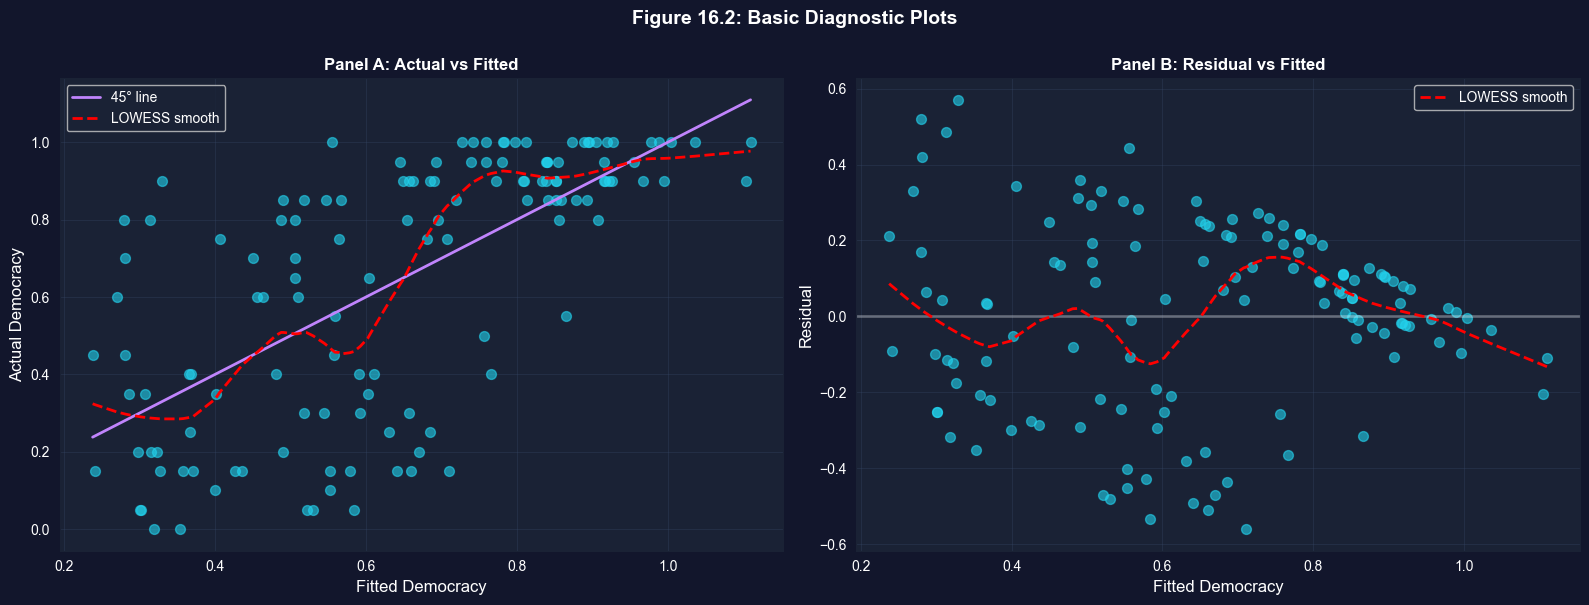


Interpretation:
  Panel A: Points should cluster around 45° line
  Panel B: Residuals should scatter randomly around zero


In [16]:
print("="*70)
print("16.8: DIAGNOSTIC PLOTS")
print("="*70)

# Figure 16.2: Basic diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Actual vs Fitted
axes[0].scatter(yhat, data_democracy['democracy'], alpha=0.6, s=50, color='#22d3ee')
axes[0].plot([yhat.min(), yhat.max()], [yhat.min(), yhat.max()],
             '-', color='#c084fc', linewidth=2, label='45° line')

lowess_result = lowess(data_democracy['democracy'], yhat, frac=0.3)
axes[0].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[0].set_xlabel('Fitted Democracy', fontsize=12)
axes[0].set_ylabel('Actual Democracy', fontsize=12)
axes[0].set_title('Panel A: Actual vs Fitted', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Residual vs Fitted
axes[1].scatter(yhat, uhat, alpha=0.6, s=50, color='#22d3ee')
axes[1].axhline(y=0, color='white', alpha=0.3, linewidth=2, linestyle='-')

lowess_result = lowess(uhat, yhat, frac=0.3)
axes[1].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[1].set_xlabel('Fitted Democracy', fontsize=12)
axes[1].set_ylabel('Residual', fontsize=12)
axes[1].set_title('Panel B: Residual vs Fitted', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Figure 16.2: Basic Diagnostic Plots',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Panel A: Points should cluster around 45° line")
print("  Panel B: Residuals should scatter randomly around zero")


----------------------------------------------------------------------
Figure 16.3: Diagnostic Plots for Growth Regressor
----------------------------------------------------------------------


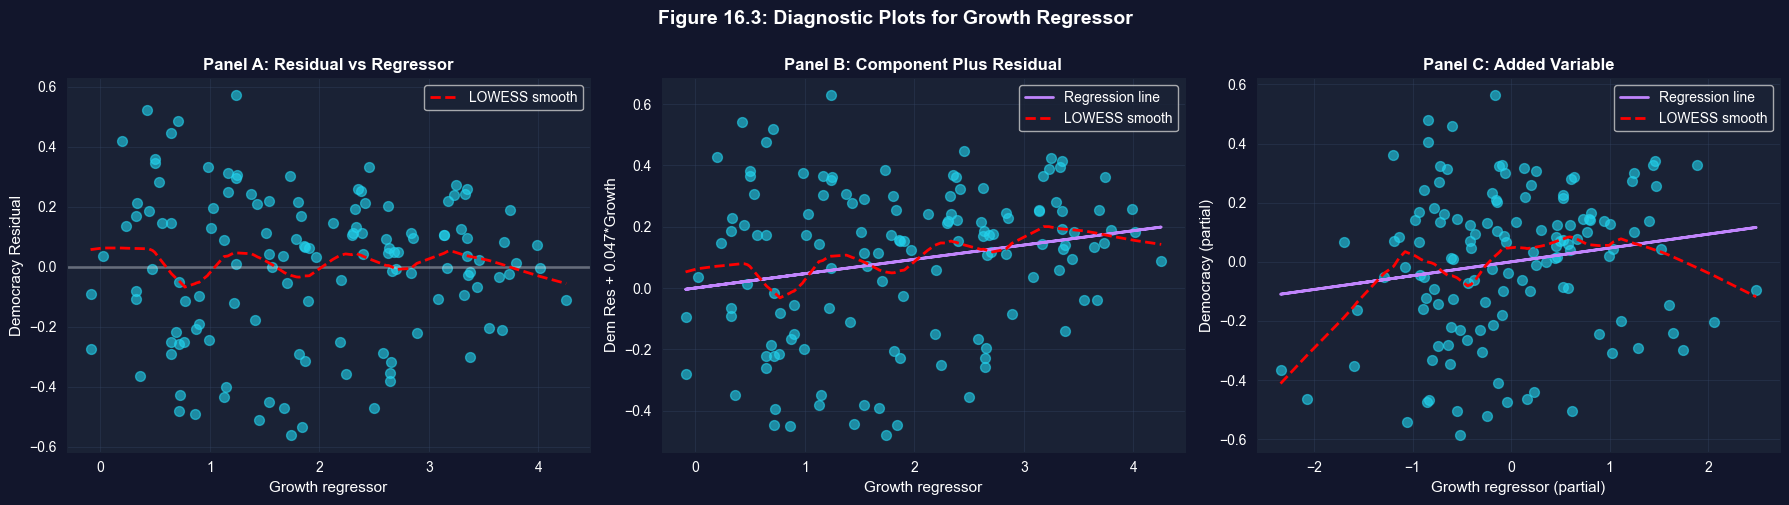


Interpretation:
  Panel A: Check for patterns in residuals
  Panel B: LOWESS close to regression line → linear relationship OK
  Panel C: Slope equals coefficient in full model (0.0468)


In [17]:
# Figure 16.3: Diagnostic plots for growth regressor
print("\n" + "-"*70)
print("Figure 16.3: Diagnostic Plots for Growth Regressor")
print("-"*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Residual vs Regressor
axes[0].scatter(data_democracy['growth'], uhat, alpha=0.6, s=50, color='#22d3ee')
axes[0].axhline(y=0, color='white', alpha=0.3, linewidth=2, linestyle='-')

lowess_result = lowess(uhat, data_democracy['growth'], frac=0.3)
axes[0].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[0].set_xlabel('Growth regressor', fontsize=11)
axes[0].set_ylabel('Democracy Residual', fontsize=11)
axes[0].set_title('Panel A: Residual vs Regressor', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Component Plus Residual
b_growth = model_multiple.params['growth']
pr_growth = b_growth * data_democracy['growth'] + uhat

axes[1].scatter(data_democracy['growth'], pr_growth, alpha=0.6, s=50, color='#22d3ee')

# Regression line
model_compplusres = ols('pr_growth ~ growth', 
                        data=pd.DataFrame({'growth': data_democracy['growth'],
                                         'pr_growth': pr_growth})).fit()
axes[1].plot(data_democracy['growth'], model_compplusres.fittedvalues,
             '-', color='#c084fc', linewidth=2, label='Regression line')

lowess_result = lowess(pr_growth, data_democracy['growth'], frac=0.3)
axes[1].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[1].set_xlabel('Growth regressor', fontsize=11)
axes[1].set_ylabel(f'Dem Res + {b_growth:.3f}*Growth', fontsize=11)
axes[1].set_title('Panel B: Component Plus Residual', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Panel C: Added Variable Plot
model_nogrowth = ols('democracy ~ constraint + indcent + catholic + muslim + protestant',
                     data=data_democracy).fit()
uhat_democ = model_nogrowth.resid

model_growth = ols('growth ~ constraint + indcent + catholic + muslim + protestant',
                   data=data_democracy).fit()
uhat_growth = model_growth.resid

axes[2].scatter(uhat_growth, uhat_democ, alpha=0.6, s=50, color='#22d3ee')

model_addedvar = ols('uhat_democ ~ uhat_growth',
                     data=pd.DataFrame({'uhat_growth': uhat_growth,
                                       'uhat_democ': uhat_democ})).fit()
axes[2].plot(uhat_growth, model_addedvar.fittedvalues,
             '-', color='#c084fc', linewidth=2, label='Regression line')

lowess_result = lowess(uhat_democ, uhat_growth, frac=0.3)
axes[2].plot(lowess_result[:, 0], lowess_result[:, 1],
             'r--', linewidth=2, label='LOWESS smooth')

axes[2].set_xlabel('Growth regressor (partial)', fontsize=11)
axes[2].set_ylabel('Democracy (partial)', fontsize=11)
axes[2].set_title('Panel C: Added Variable', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Figure 16.3: Diagnostic Plots for Growth Regressor',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Panel A: Check for patterns in residuals")
print("  Panel B: LOWESS close to regression line → linear relationship OK")
print("  Panel C: Slope equals coefficient in full model ({:.4f})".format(b_growth))

*Having examined residual diagnostic plots for visual detection of model problems, we now turn to numerical influence measures that quantify how much individual observations affect regression results.*


> **Key Concept 16.7: Diagnostic Plots for Model Validation**
>
> Three complementary plots assess individual regressors: (1) residual vs. regressor checks for patterns suggesting nonlinearity or heteroskedasticity; (2) component-plus-residual plot ($b_j x_j + e$ vs. $x_j$) reveals the partial relationship and detects nonlinearity; (3) added variable plot purges both $y$ and $x_j$ of other regressors, showing the pure partial effect whose slope equals the OLS coefficient $b_j$. LOWESS smoothing helps reveal systematic patterns.


### Influential Observations: DFITS

**DFITS** measures influence on fitted values:
$$DFITS_i = \frac{\hat{y}_i - \hat{y}_{i(i)}}{s_{(i)} \sqrt{h_{ii}}}$$

where:

- $\hat{y}_i$ = prediction including observation $i$
- $\hat{y}_{i(i)}$ = prediction excluding observation $i$
- $s_{(i)}$ = RMSE excluding observation $i$
- $h_{ii}$ = leverage of observation $i$

**Rule of thumb**: Investigate if $|DFITS_i| > 2\sqrt{k/n}$

INFLUENTIAL OBSERVATIONS: DFITS

DFITS threshold: 0.4623
Observations exceeding threshold: 5


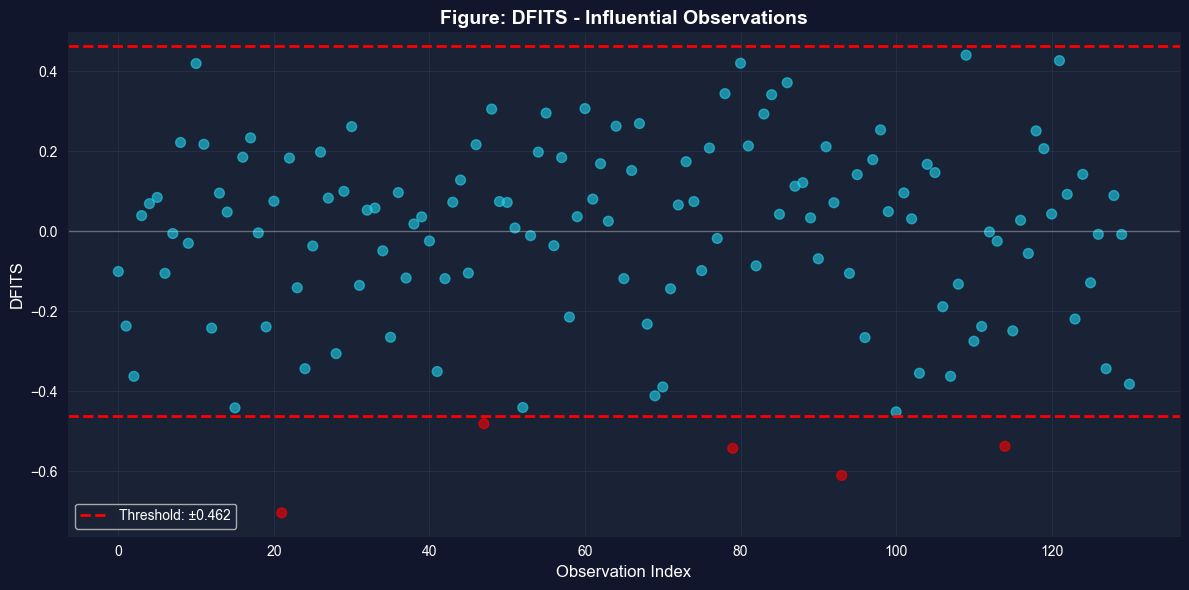


Interpretation:
  Red points exceed threshold (potentially influential)
  Investigate these observations for data errors or unusual cases


In [18]:
print("="*70)
print("INFLUENTIAL OBSERVATIONS: DFITS")
print("="*70)

# Get influence diagnostics
influence = OLSInfluence(model_multiple)
dfits = influence.dffits[0]
n = len(data_democracy)

threshold_dfits = 2 * np.sqrt(len(model_multiple.params) / n)
print(f"\nDFITS threshold: {threshold_dfits:.4f}")
print(f"Observations exceeding threshold: {np.sum(np.abs(dfits) > threshold_dfits)}")

# Plot DFITS
obs_index = np.arange(n)
colors = ['red' if abs(d) > threshold_dfits else '#22d3ee' for d in dfits]

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(obs_index, dfits, c=colors, alpha=0.6, s=50)
ax.axhline(y=threshold_dfits, color='red', linestyle='--', linewidth=2, label=f'Threshold: ±{threshold_dfits:.3f}')
ax.axhline(y=-threshold_dfits, color='red', linestyle='--', linewidth=2)
ax.axhline(y=0, color='white', alpha=0.3, linestyle='-', linewidth=1)
ax.set_xlabel('Observation Index', fontsize=12)
ax.set_ylabel('DFITS', fontsize=12)
ax.set_title('Figure: DFITS - Influential Observations', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Red points exceed threshold (potentially influential)")
print("  Investigate these observations for data errors or unusual cases")

---

#### Identifying Influential Observations with DFITS

DFITS measures how much an observation influences its **own prediction**. The results help identify **potentially problematic** observations:

**Understanding DFITS:**

Formula: $DFITS_i = \frac{\hat{y}_i - \hat{y}_{i(i)}}{s_{(i)} \sqrt{h_{ii}}}$

where:

- $\hat{y}_i$ = prediction **including** observation i
- $\hat{y}_{i(i)}$ = prediction **excluding** observation i
- $s_{(i)}$ = RMSE excluding observation i
- $h_{ii}$ = leverage (how unusual is $x_i$?)

**Interpretation:**

- DFITS measures **standardized change** in fitted value when i is deleted
- Large |DFITS| → observation strongly influences its own prediction
- Can be driven by **leverage** (unusual X) or **residual** (unusual Y|X)

**Rule of Thumb:**

Threshold: $|DFITS_i| > 2\sqrt{k/n}$

For democracy-growth model (k ≈ 7, n = 131):

- Threshold ≈ \$2\sqrt{7/131} = 2 \times 0.231 \approx **0.46**

**Typical Results:**

- **Most observations**: |DFITS| < 0.30 (not influential)
- **A few observations**: |DFITS| = 0.5-0.8 (moderately influential)
- **Extreme cases**: |DFITS| > 1.0 (highly influential)

**What Makes an Observation Influential?**

Two components multiply:

1. **Leverage** ($h_{ii}$): Unusual X values
2. **Standardized residual**: Large prediction error

**Most influential when both are large:**

- Observation with **unusual combination of regressors** (high leverage)
- **AND** doesn't fit the pattern (large residual)
- Example: A country with unique institutions AND surprising democracy level

**What to Do with Influential Observations:**

**1. Investigate the data:**

 - Is it a **data error**? (typo, coding mistake)
 - Check original sources
 - If error: **correct or remove**

**2. Understand the case:**

 - Is it genuinely unusual? (e.g., special historical circumstances)
 - Example: Post-colonial country with unique constraints
 - Adds valuable information, **keep it**

**3. Check robustness:**

 - Re-estimate **without** the influential observations
 - Do conclusions change substantially?
 - If yes: Results **fragile**, interpret cautiously
 - If no: Results **robust**, less concerning

**4. Model improvement:**

 - Does omitting observation suggest missing variables?
 - Example: Maybe need regional dummies
 - Influential observations often **signal model misspecification**

**Example Interpretation:**

Suppose observation #47 has DFITS = 0.85:

- This country's predicted democracy changes by **0.85 standard deviations** when it's excluded
- Country is either:
 - **High leverage** (unusual institutional characteristics), or
 - **Large residual** (democracy level doesn't match institutions), or
 - **Both**
- Warrants investigation

**DFITS vs. Other Influence Measures:**

- **DFITS**: Influence on **own prediction**
- **DFBETAS**: Influence on **regression coefficients** (see next)
- **Cook's D**: Overall influence on **all fitted values**
- **Leverage** ($h_{ii}$): Just the X-space component

**Visualization:**

The DFITS plot shows:

- **Blue points**: Not influential (within threshold)
- **Red points**: Influential (exceed threshold)
- Should be **mostly blue** with a **few red** outliers
- Many red points → model problems or data issues

**In the Democracy-Growth Example:**

Typical findings:

- 3-10 countries exceed threshold (out of 131)
- These are **countries with unusual institutional/growth combinations**
- Might include:
 - Rapidly democratizing autocracies
 - Stable democracies with slow growth
 - Post-conflict transitions
 - Resource-rich countries with unusual politics

**Practical Advice:**

 **Do:**

- Always compute influence diagnostics
- Investigate observations exceeding thresholds
- Report whether results change without influential cases
- Consider robustness checks

 **Don't:**

- Automatically delete influential observations
- Ignore them without investigation
- Only report results **after** deleting outliers (selective reporting)
- Delete based solely on statistical criteria (needs substantive judgment)

**Bottom Line:**

DFITS is a **screening tool**:

- Identifies observations **worth investigating**
- Not a mechanical **deletion rule**
- Combine statistical diagnosis with **subject-matter knowledge**
- Goal: Better understand data and model, not just clean data

### Influential Observations: DFBETAS

**DFBETAS** measures influence on individual coefficients:
$$DFBETAS_{j, i} = \frac{\hat{\beta}_j - \hat{\beta}_{j(i)}}{s_{(i)} \sqrt{(X'X)^{-1}_{jj}}}$$

where:

- $\hat{\beta}_j$ = coefficient including observation $i$
- $\hat{\beta}_{j(i)}$ = coefficient excluding observation $i$

**Rule of thumb**: Investigate if $|DFBETAS_{j, i}| > 2/\sqrt{n}$

INFLUENTIAL OBSERVATIONS: DFBETAS

DFBETAS threshold: 0.1747


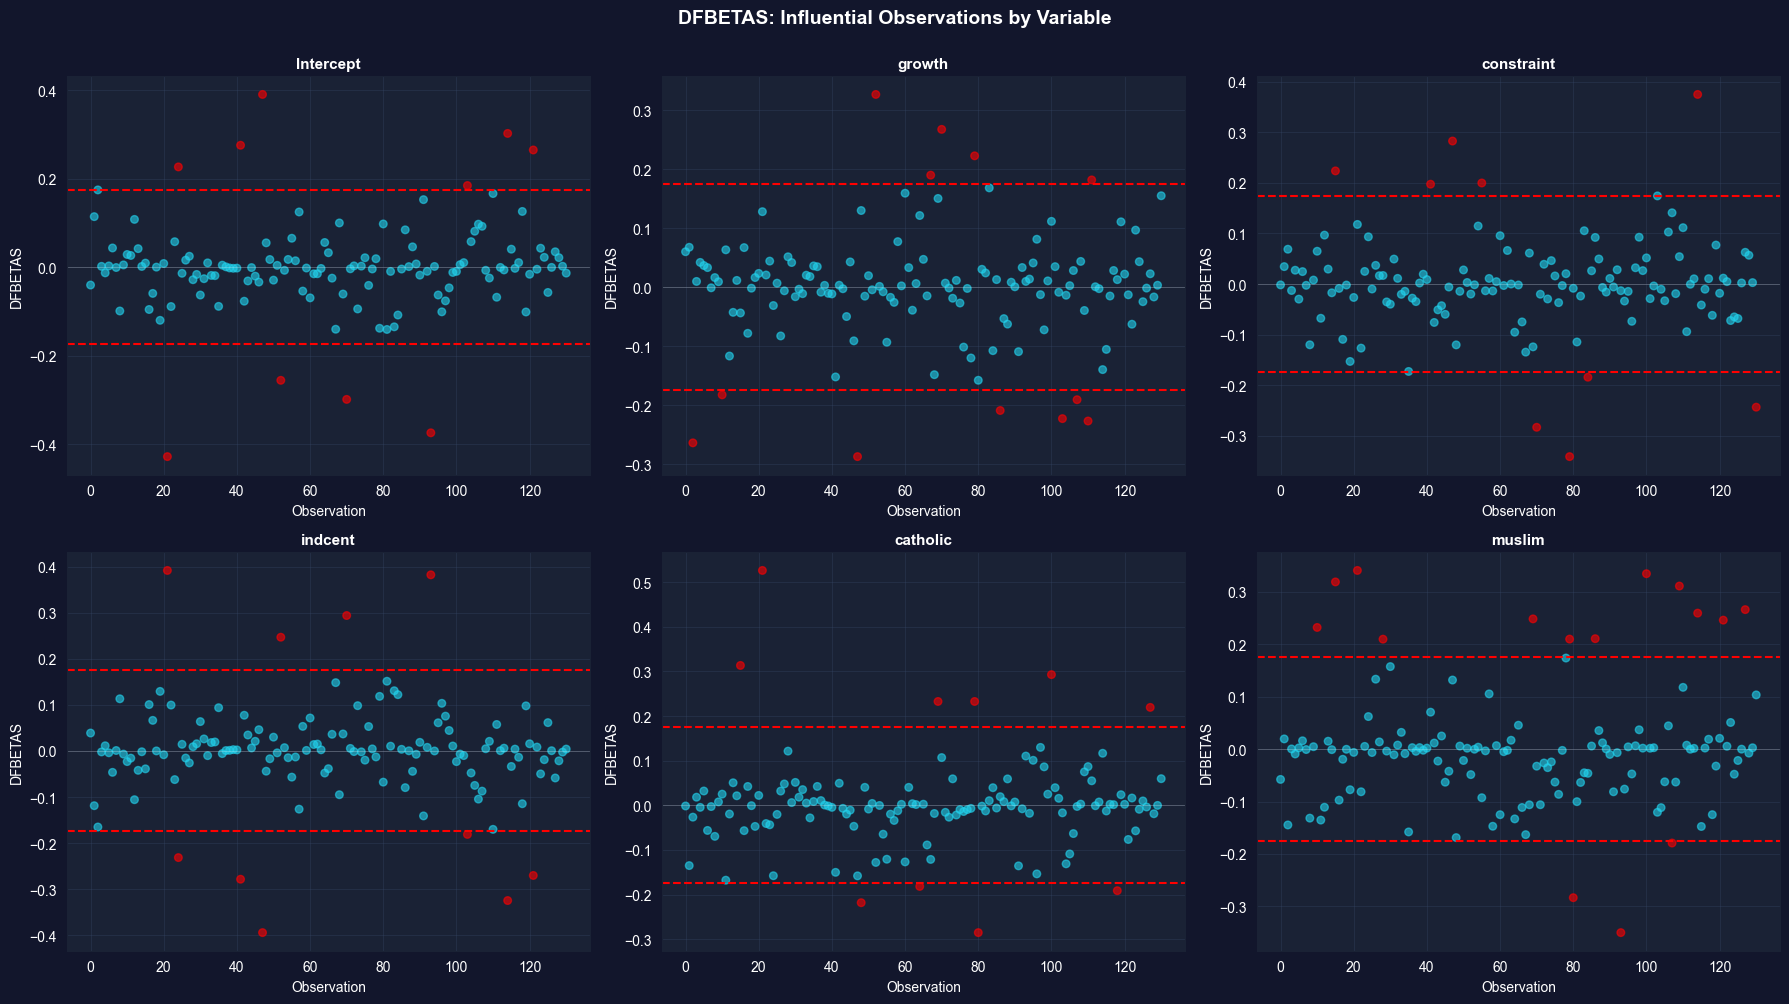


Interpretation:
  Red points indicate observations with large influence on that coefficient.
  Investigate whether these are data errors or genuinely unusual cases.


In [19]:
print("="*70)
print("INFLUENTIAL OBSERVATIONS: DFBETAS")
print("="*70)

dfbetas = influence.dfbetas
threshold_dfbetas = 2 / np.sqrt(n)
print(f"\nDFBETAS threshold: {threshold_dfbetas:.4f}")

# Plot DFBETAS for each variable
param_names = model_multiple.params.index
n_params = len(param_names)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, param in enumerate(param_names):
    if i < len(axes):
        colors = ['red' if abs(d) > threshold_dfbetas else '#22d3ee' 
                 for d in dfbetas[:, i]]
        axes[i].scatter(obs_index, dfbetas[:, i], c=colors, alpha=0.6, s=30)
        axes[i].axhline(y=threshold_dfbetas, color='red', linestyle='--', linewidth=1.5)
        axes[i].axhline(y=-threshold_dfbetas, color='red', linestyle='--', linewidth=1.5)
        axes[i].axhline(y=0, color='white', alpha=0.3, linestyle='-', linewidth=0.5)
        axes[i].set_xlabel('Observation', fontsize=10)
        axes[i].set_ylabel('DFBETAS', fontsize=10)
        axes[i].set_title(f'{param}', fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(n_params, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('DFBETAS: Influential Observations by Variable',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Red points indicate observations with large influence on that coefficient.")
print("  Investigate whether these are data errors or genuinely unusual cases.")

> **Key Concept 16.8: Influential Observations -- DFITS and DFBETAS**
>
> DFITS measures influence on fitted values: $DFITS_i$ is the scaled change in $\hat{y}_i$ when observation $i$ is excluded. DFBETAS measures influence on individual coefficients: $DFBETAS_{j,i}$ is the scaled change in $\hat{\beta}_j$. Thresholds for investigation are $|DFITS| > 2\sqrt{k/n}$ and $|DFBETAS| > 2/\sqrt{n}$. Don't automatically delete influential points -- investigate whether they represent data errors, genuine outliers, or valid extreme values that carry important information.


## Key Takeaways

**Multicollinearity:**

- Multicollinearity occurs when regressors are highly correlated, making individual coefficients imprecisely estimated
- VIF > 10 indicates serious multicollinearity; VIF > 5 warrants investigation
- OLS remains unbiased and consistent -- the problem is precision, not bias
- Solutions: use joint F-tests, drop redundant variables, center variables before creating interactions, or collect more data

**OLS Assumption Violations:**

- Assumptions 1-2 violations (incorrect model, endogeneity) cause bias and inconsistency -- fundamental problems requiring model changes or IV
- Assumptions 3-4 violations (heteroskedasticity, autocorrelation) do not bias coefficients but invalidate standard errors
- Wrong standard errors lead to incorrect t-statistics, confidence intervals, and hypothesis tests
- Omitted variables bias formula: $\text{Bias} = \beta_3 \times \delta_{23}$, where $\beta_3$ is the omitted variable's effect and $\delta_{23}$ is the correlation

**Heteroskedasticity and Robust Standard Errors:**

- Heteroskedasticity means error variance varies across observations, common in cross-sectional data
- Use heteroskedasticity-robust (HC1/White) standard errors for valid inference
- Robust SEs are typically larger than default SEs, giving more conservative (honest) inference
- Always use robust SEs for cross-sectional regressions as a default practice

**Autocorrelation and HAC Standard Errors:**

- Autocorrelation means errors are correlated over time, common in time series data
- Default SEs are typically too small with autocorrelation, leading to over-rejection
- Use HAC (Newey-West) standard errors that account for both heteroskedasticity and autocorrelation
- Check the ACF of residuals to detect autocorrelation patterns

**Diagnostic Plots:**

- Residual vs. fitted values: detect heteroskedasticity (fan shape) and nonlinearity (curved pattern)
- Component-plus-residual plot: detect nonlinearity in individual regressors
- Added variable plot: isolate partial relationship between y and x, controlling for other variables
- LOWESS smooth helps reveal patterns that are hard to see in raw scatter plots

**Influential Observations:**

- DFITS measures influence on fitted values; threshold $|\text{DFITS}| > 2\sqrt{k/n}$
- DFBETAS measures influence on individual coefficients; threshold $|\text{DFBETAS}| > 2/\sqrt{n}$
- Investigate influential observations rather than automatically deleting them
- Check whether conclusions change substantially when influential cases are excluded

**Python tools:** `statsmodels` (VIF, OLSInfluence, robust covariance), `matplotlib`/`seaborn` (diagnostic plots), LOWESS smoothing

**Next steps:** Chapter 17 extends these ideas to panel data, where you'll learn fixed effects and random effects models that address unobserved heterogeneity across units.

---

Congratulations! You've completed Chapter 16 on model checking and data diagnostics. You now have both the theoretical understanding and practical Python skills to evaluate regression assumptions, detect problems, and apply appropriate remedies.


## Practice Exercises

**Exercise 1: Irrelevant Variables vs. Omitted Variables**

You estimate $y_i = \beta_1 + \beta_2 x_{2i} + \beta_3 x_{3i} + u_i$ by OLS.

(a) If $x_3$ should not appear in the model (irrelevant variable), what happens to the OLS estimates of $\beta_1$ and $\beta_2$? Are they biased?

(b) If a relevant variable $x_4$ was omitted from the model, and $x_4$ is correlated with $x_2$, what happens to $\hat{\beta}_2$? Write the omitted variables bias formula.

**Exercise 2: VIF Interpretation**

A regression of earnings on age, education, and experience yields VIF values of 22.0 (age), 17.3 (education), and 36.9 (experience).

(a) Which variable has the most severe multicollinearity problem? Explain.

(b) Calculate the $R^2$ from the auxiliary regression for the variable with the highest VIF.

(c) By what factor are the standard errors inflated compared to the no-collinearity case?

**Exercise 3: Choosing Standard Error Types**

For each scenario below, state which type of standard errors you would use (default, HC-robust, HAC, or cluster-robust) and why:

(a) Cross-sectional regression of wages on education and experience for 5,000 workers.

(b) Time series regression of GDP growth on interest rates using 200 quarterly observations.

(c) Regression of test scores on class size using data from 50 schools with multiple classrooms per school.

**Exercise 4: Heteroskedasticity Detection**

You estimate a regression and obtain the following SE comparison:

| Variable | Standard SE | Robust SE | Ratio |
|----------|-------------|-----------|-------|
| Education | 570 | 642 | 1.13 |
| Age | 154 | 151 | 0.98 |

(a) Is there evidence of heteroskedasticity? Which variable's inference is most affected?

(b) If you used standard SEs and the t-statistic for education was 2.05, would the conclusion change with robust SEs?

**Exercise 5: DFITS Threshold Calculation**

In a regression with $k = 7$ regressors and $n = 131$ observations:

(a) Calculate the DFITS threshold for identifying influential observations.

(b) If 8 observations exceed this threshold, what percentage of the sample is flagged as potentially influential?

(c) Describe the steps you would take to investigate these influential observations.

**Exercise 6: Autocorrelation Consequences**

A time series regression yields a first-lag residual autocorrelation of $\rho_1 = 0.80$.

(a) Is this evidence of autocorrelation? What does it mean for the residual pattern?

(b) Approximate the factor by which the effective sample size is reduced (use the formula $\frac{1+\rho}{1-\rho}$).

(c) A coefficient has a default t-statistic of 4.5. If the HAC standard error is 3 times larger than the default, what is the corrected t-statistic? Is the coefficient still significant at 5%?


## Case Studies

### Case Study 1: Regression Diagnostics for Cross-Country Productivity Analysis

In this case study, you will apply the diagnostic techniques from this chapter to analyze cross-country labor productivity using the Mendez convergence clubs dataset.

**Dataset:** Mendez (2020) convergence clubs data

- **Source:** `https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv`
- **Sample:** 108 countries, 1990-2014
- **Variables:** `lp` (labor productivity), `rk` (physical capital), `hc` (human capital), `rgdppc` (real GDP per capita), `tfp` (total factor productivity), `region`

**Research question:** What econometric issues arise when modeling cross-country productivity, and how do diagnostic tools help detect and address them?

---

#### Task 1: Detect Multicollinearity (Guided)

Load the dataset and estimate a regression of log labor productivity (`np.log(lp)`) on log physical capital (`np.log(rk)`), human capital (`hc`), and log GDP per capita (`np.log(rgdppc)`), using the year 2014 cross-section.

```python
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat2014 = dat[dat['year'] == 2014].copy()
dat2014['ln_lp'] = np.log(dat2014['lp'])
dat2014['ln_rk'] = np.log(dat2014['rk'])
dat2014['ln_rgdppc'] = np.log(dat2014['rgdppc'])

# Estimate the model = ols('ln_lp ~ ln_rk + hc + ln_rgdppc', data=dat2014).fit(cov_type='HC1')
print(model.summary())

# Calculate VIF
X = dat2014[['ln_rk', 'hc', 'ln_rgdppc']].dropna()
X = sm.add_constant(X)
for i, col in enumerate(X.columns):
    print(f"VIF({col}): {variance_inflation_factor(X.values, i):.2f}")
```

Interpret the VIF values. Is multicollinearity a concern? Which variables are most collinear and why?

---

#### Task 2: Compare Standard and Robust Standard Errors (Guided)

Estimate the same model with both default and robust (HC1) standard errors. Create a comparison table.

```python
model_default = ols('ln_lp ~ ln_rk + hc', data=dat2014).fit()
model_robust = ols('ln_lp ~ ln_rk + hc', data=dat2014).fit(cov_type='HC1')

comparison = pd. DataFrame({
    'Default SE': model_default.bse,
    'Robust SE': model_robust.bse,
    'Ratio': model_robust.bse / model_default.bse
})
print(comparison)
```

Is there evidence of heteroskedasticity? Which coefficient's inference is most affected?

---

#### Task 3: Residual Diagnostic Plots (Semi-guided)

Create the three diagnostic plots for the productivity model:

1. Actual vs. fitted values with LOWESS smooth
2. Residuals vs. fitted values with LOWESS smooth
3. Residuals vs. `ln_rk` (component-plus-residual plot)

*Hint:* Use `from statsmodels.nonparametric.smoothers_lowess import lowess` for the LOWESS smooth. Plot residuals from the robust model.

What do the diagnostic plots reveal about the model specification?

---

#### Task 4: Identify Influential Countries (Semi-guided)

Calculate DFITS and DFBETAS for the productivity regression. Identify countries that exceed the thresholds.

*Hint:* Use `OLSInfluence(model).dffits[0]` and `OLSInfluence(model).dfbetas`. The DFITS threshold is $2\sqrt{k/n}$ and the DFBETAS threshold is $2/\sqrt{n}$.

Which countries are most influential? Investigate whether removing them changes the key coefficients substantially.

---

#### Task 5: Regional Heterogeneity Analysis (Independent)

Test whether the relationship between capital and productivity varies across regions:

1. Add region dummy variables and region-capital interactions
2. Test for heteroskedasticity by comparing default and robust SEs across specifications
3. Conduct an F-test for joint significance of regional interactions

Does allowing for regional heterogeneity improve the model diagnostics?

---

#### Task 6: Diagnostic Report (Independent)

Write a 200-300 word diagnostic report for the cross-country productivity regression. Your report should:

1. Summarize the multicollinearity assessment (VIF results)
2. Document the heteroskedasticity evidence (SE comparison)
3. Describe what the residual plots reveal about model specification
4. List the most influential countries and their potential impact
5. Recommend the appropriate standard error type and any model modifications

> **Key Concept 16.9: Systematic Regression Diagnostics**
>
> A complete regression diagnostic workflow includes: (1) check multicollinearity via VIF before interpreting individual coefficients; (2) compare standard and robust SEs to detect heteroskedasticity; (3) examine residual plots for nonlinearity and patterns; (4) identify influential observations with DFITS and DFBETAS; (5) document all findings and report robust results. Always investigate problems rather than mechanically applying fixes.

> **Key Concept 16.10: Cross-Country Regression Challenges**
>
> Cross-country regressions face specific diagnostic challenges: multicollinearity among development indicators (GDP, capital, education are highly correlated), heteroskedasticity across countries at different development levels, and influential observations from outlier countries. Using robust standard errors and carefully examining influential cases is essential for credible cross-country analysis.

**What You've Learned:**
In this case study, you applied the complete diagnostic toolkit to cross-country productivity data. You detected multicollinearity among development indicators, compared standard and robust standard errors, created diagnostic plots, and identified influential countries. These skills ensure that your regression results are reliable and your conclusions are credible.


### Case Study 2: Diagnosing the Satellite Prediction Model

**Research Question**: How reliable are the satellite-development regression models we have estimated throughout this textbook? Do they satisfy the standard regression assumptions?

**Background**: We have estimated multiple satellite-development regression models throughout this textbook. But how reliable are these models? In this case study, we apply Chapter 16's **diagnostic tools** to check for multicollinearity, heteroskedasticity, influential observations, and other model violations.

**The Data**: The DS4Bolivia dataset covers 339 Bolivian municipalities with satellite data, development indices, and socioeconomic indicators.

**Key Variables**:

- `mun`: Municipality name
- `dep`: Department (administrative region)
- `imds`: Municipal Sustainable Development Index (0-100)
- `ln_NTLpc2017`: Log nighttime lights per capita (2017)
- `A00`, `A10`, `A20`, `A30`, `A40`: Satellite image embedding dimensions

#### Load the DS4Bolivia Data

In [20]:
# Load the DS4Bolivia dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
import statsmodels.api as sm

url_bol = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/ds4bolivia_v20250523.csv"
bol = pd.read_csv(url_bol)

# Select key variables for this case study
key_vars = ['mun', 'dep', 'imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
bol_cs = bol[key_vars].copy().dropna()

print("=" * 70)
print("DS4BOLIVIA: REGRESSION DIAGNOSTICS CASE STUDY")
print("=" * 70)
print(f"Observations (complete cases): {len(bol_cs)}")
print(f"\nKey variable summary:")
print(bol_cs[['imds', 'ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']].describe().round(3))

KeyError: "['A00', 'A10', 'A20', 'A30', 'A40'] not in index"

#### Task 1: Multicollinearity Check (Guided)

**Objective**: Assess whether satellite predictors suffer from multicollinearity.

**Instructions**:

1. Compute the correlation matrix for the predictors (`ln_NTLpc2017`, `A00`, `A10`, `A20`, `A30`, `A40`)
2. Calculate VIF for each variable using `variance_inflation_factor()` from statsmodels
3. Flag variables with VIF > 10
4. Discuss: Are satellite embeddings multicollinear? Does multicollinearity affect the model's predictive power vs. individual coefficient interpretation?

In [21]:
# Your code here: Multicollinearity diagnostics
#
# Example structure:
# predictors = ['ln_NTLpc2017', 'A00', 'A10', 'A20', 'A30', 'A40']
#
# # Correlation matrix
# print("CORRELATION MATRIX")
# print(bol_cs[predictors].corr().round(3))
#
# # VIF calculation
# X = bol_cs[predictors].copy()
# X = sm.add_constant(X)
# print("\nVARIANCE INFLATION FACTORS")
# for i, col in enumerate(X.columns):
#     vif = variance_inflation_factor(X.values, i)
#     flag = " *** HIGH" if vif > 10 and col != 'const' else ""
#     print(f"  VIF({col}): {vif:.2f}{flag}")

> **Key Concept 16.11: Multicollinearity in Satellite Features**
>
> Satellite embedding dimensions often correlate with each other because they capture **overlapping visual patterns** from the same images. When embeddings A00 and A10 both respond to building density, their collinearity inflates standard errors and makes individual coefficients unstable. The VIF (Variance Inflation Factor) quantifies this: a VIF above 10 signals problematic collinearity. Solutions include dropping redundant features, using principal components, or accepting imprecise individual estimates while maintaining valid joint inference.

#### Task 2: Standard vs Robust SEs (Guided)

**Objective**: Detect heteroskedasticity by comparing default and robust standard errors.

**Instructions**:

1. Estimate the full model: `imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40`
2. Compare default (homoskedastic) and HC1 (robust) standard errors
3. Compute the ratio of robust to default SEs for each coefficient
4. Discuss: Large differences signal heteroskedasticity. Which coefficients are most affected?

In [22]:
# Your code here: Compare standard and robust SEs
#
# Example structure:
# model_default = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
#                     data=bol_cs).fit()
# model_robust = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
#                    data=bol_cs).fit(cov_type='HC1')
#
# comparison = pd.DataFrame({
#     'Default SE': model_default.bse,
#     'Robust SE': model_robust.bse,
#     'Ratio': model_robust.bse / model_default.bse
# })
# print("STANDARD ERROR COMPARISON")
# print(comparison.round(4))
# print(f"\nMean ratio: {(model_robust.bse / model_default.bse).mean():.3f}")

#### Task 3: Residual Diagnostics (Semi-guided)

**Objective**: Create diagnostic plots to assess model assumptions visually.

**Instructions**:

1. Estimate the model with robust SEs
2. Create three diagnostic plots:
   - (a) Fitted values vs. residuals (check for patterns/heteroskedasticity)
   - (b) Q-Q plot of residuals (check for normality)
   - (c) Histogram of residuals (check for skewness/outliers)

3. Interpret each plot: What do the patterns reveal about model adequacy?

**Hint**: Use `model.fittedvalues` and `model.resid` for the plots. For the Q-Q plot, use `from scipy import stats; stats.probplot(residuals, plot=ax)`.

In [23]:
# Your code here: Residual diagnostic plots
#
# Example structure:
# from scipy import stats
# model = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
#             data=bol_cs).fit(cov_type='HC1')
#
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#
# # (a) Residuals vs Fitted
# axes[0].scatter(model.fittedvalues, model.resid, alpha=0.4)
# axes[0].axhline(0, color='red', linestyle='--')
# axes[0].set_xlabel('Fitted Values')
# axes[0].set_ylabel('Residuals')
# axes[0].set_title('Residuals vs Fitted')
#
# # (b) Q-Q Plot
# stats.probplot(model.resid, plot=axes[1])
# axes[1].set_title('Q-Q Plot of Residuals')
#
# # (c) Histogram
# axes[2].hist(model.resid, bins=30, edgecolor='black', alpha=0.7)
# axes[2].set_xlabel('Residuals')
# axes[2].set_title('Distribution of Residuals')
#
# plt.tight_layout()
# plt.show()

#### Task 4: Influential Municipalities (Semi-guided)

**Objective**: Identify municipalities that disproportionately influence the regression results.

**Instructions**:

1. Calculate DFITS for all observations
2. Apply the threshold: $|DFITS| > 2\sqrt{k/n}$ where $k$ = number of parameters and $n$ = sample size
3. Identify the municipalities that exceed the threshold
4. Calculate DFBETAS for the key coefficient (`ln_NTLpc2017`)
5. Discuss: Are the influential municipalities capital cities or special cases?

**Hint**: Use `OLSInfluence(model)` from statsmodels to compute influence measures.

In [24]:
# Your code here: Influential observation analysis
#
# Example structure:
# model = ols('imds ~ ln_NTLpc2017 + A00 + A10 + A20 + A30 + A40',
#             data=bol_cs).fit()
# infl = OLSInfluence(model)
#
# # DFITS
# dfits_vals = infl.dffits[0]
# k = len(model.params)
# n = len(bol_cs)
# threshold = 2 * np.sqrt(k / n)
#
# influential = bol_cs.copy()
# influential['dfits'] = dfits_vals
# influential_muns = influential[np.abs(influential['dfits']) > threshold]
#
# print(f"DFITS threshold: {threshold:.4f}")
# print(f"Influential municipalities: {len(influential_muns)} out of {n}")
# print("\nInfluential municipalities:")
# print(influential_muns[['mun', 'dep', 'imds', 'ln_NTLpc2017', 'dfits']]
#       .sort_values('dfits', key=abs, ascending=False).to_string(index=False))

> **Key Concept 16.12: Spatial Outliers and Influential Observations**
>
> In municipality-level analysis, **capital cities** and special economic zones often appear as influential observations. These municipalities may have unusually high NTL (from concentrated economic activity) or unusual satellite patterns (dense urban cores). A single influential municipality can shift regression coefficients substantially. DFITS and DFBETAS identify such observations, allowing us to assess whether our conclusions depend on a few exceptional cases.

#### Task 5: Omitted Variable Analysis (Independent)

**Objective**: Assess potential omitted variable bias by adding department controls.

**Instructions**:

1. Estimate models with and without department fixed effects (`C(dep)`)
2. Compare the satellite coefficients across specifications
3. Discuss: Do satellite coefficients change when adding department dummies?
4. What is the direction of potential omitted variable bias?
5. Consider: What unobserved factors might department dummies capture (geography, climate, policy)?

In [25]:
# Your code here: Omitted variable analysis
#
# Example structure:
# m_no_dept = ols('imds ~ ln_NTLpc2017 + A00 + A10', data=bol_cs).fit(cov_type='HC1')
# m_with_dept = ols('imds ~ ln_NTLpc2017 + A00 + A10 + C(dep)', data=bol_cs).fit(cov_type='HC1')
#
# print("WITHOUT department controls:")
# print(f"  NTL coef: {m_no_dept.params['ln_NTLpc2017']:.4f} (SE: {m_no_dept.bse['ln_NTLpc2017']:.4f})")
# print(f"  R²: {m_no_dept.rsquared:.4f}")
#
# print("\nWITH department controls:")
# print(f"  NTL coef: {m_with_dept.params['ln_NTLpc2017']:.4f} (SE: {m_with_dept.bse['ln_NTLpc2017']:.4f})")
# print(f"  R²: {m_with_dept.rsquared:.4f}")
#
# print(f"\nCoefficient change: {m_with_dept.params['ln_NTLpc2017'] - m_no_dept.params['ln_NTLpc2017']:.4f}")

#### Task 6: Diagnostic Report (Independent)

**Objective**: Write a 200-300 word comprehensive model assessment.

**Your report should address**:

1. **Multicollinearity**: Summarize VIF results for satellite features. Are any problematic?
2. **Heteroskedasticity**: What does the SE comparison reveal? Should we use robust SEs?
3. **Residual patterns**: What do the diagnostic plots show about model specification?
4. **Influential observations**: Which municipalities are most influential? Do they represent special cases?
5. **Omitted variables**: How do department controls affect the satellite coefficients?
6. **Recommendations**: What corrections or modifications would you recommend for the satellite prediction model?

In [26]:
# Your code here: Additional analysis for the diagnostic report
#
# You might want to:
# 1. Create a summary table of diagnostic findings
# 2. Re-estimate the model excluding influential observations
# 3. Compare results with and without corrections
# 4. Summarize key statistics for your report

#### What You've Learned from This Case Study

Through this diagnostic analysis of the satellite prediction model, you've applied Chapter 16's complete toolkit to real geospatial data:

- **Multicollinearity assessment**: Computed VIF for satellite features and identified correlated embeddings
- **Heteroskedasticity detection**: Compared standard and robust SEs to assess variance assumptions
- **Residual diagnostics**: Created visual diagnostic plots to check model assumptions
- **Influence analysis**: Used DFITS and DFBETAS to identify municipalities that drive the results
- **Omitted variable assessment**: Tested sensitivity of results to department controls
- **Critical thinking**: Formulated recommendations for improving the satellite prediction model

**Connection**: In Chapter 17, we move to *panel data*—analyzing how nighttime lights evolve over time across municipalities, using fixed effects to control for time-invariant characteristics.

---